# 课题 社零额预测 （建模部分）
1.rnn建模 

2.tcn建模

3.利用分类数据建立环比增长模型

In [5]:
#载入相关库
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")

from pandas import Series, DataFrame
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense,GRU,Conv1D,Flatten

from sklearn.metrics import mean_squared_error
from math import sqrt
from keras import backend as K

In [8]:
'''
准备工作
'''
#载入数据
f = open('时间序列预测.csv')
data = pd.read_csv(f, parse_dates=['time'], index_col='time')
index = pd.date_range(start='2008-1', end='2018-7', freq='MS')
data.index=index
#rmse函数 （keras和时间序列通用）
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


# 时间序列预测 
## 预测方式：SARIMA(1,2,1)*(0,2,1,12)
数据：以2008到2016年数据为训练集，2017年1月到2018年7月为测试集

In [9]:
mod = sm.tsa.statespace.SARIMAX(data[:108],
                                order=(1, 2, 1),
                                seasonal_order=(0, 2, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-07-01'),dynamic=False)
pred_ci = pred.conf_int()


#滚动预测，只利用现有数据预测下一期数据
y_forecasted=pd.Series([])
for i in range(108,127):
    mod = sm.tsa.statespace.SARIMAX(data[:i],
                                order=(1, 2, 1),
                                seasonal_order=(0, 2, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    pred = results.get_forecast(step=1)
    pred_ci = pred.conf_int()
    tmp = pred.predicted_mean
    y_forecasted=y_forecasted.append(tmp)


y_sarima=y_forecasted
y_truth = data['2017-01-01':]





sarima模型在测试集上的rmse：  37.605418698404854


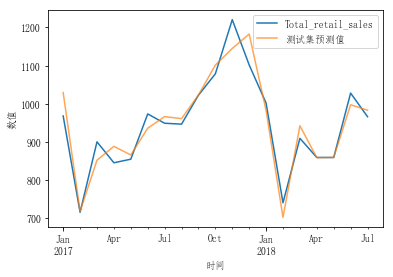

In [10]:
# Compute the mean square error
y_truth = data['2017-01-01':]
rmse_sarima=np.sqrt(mean_squared_error(y_forecasted,np.array( y_truth['Total_retail_sales'])))
print('sarima模型在测试集上的rmse： ',rmse_sarima)
ax =y_truth.plot(label='测试集观测值')
y_sarima.plot(ax=ax, label='测试集预测值', alpha=.7)
ax.set_xlabel('时间')
ax.set_ylabel('数值')
plt.legend()
plt.show()


# 预测八月份九月份

In [11]:
def predict_sarima(data):
    mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 2, 1),
                                seasonal_order=(0, 2, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    pred = results.get_forecast(step=1)
    return pred.predicted_mean

#预测八月
print('八月真实值：991.5')
print('八月预测值')
predict_sarima_8=predict_sarima(data).values[0]
print(predict_sarima_8)

#预测九月

data.ix['2018-08-01']=991.5
print('九月真实值：1032.1')
print('九月预测值：')
predict_sarima_9=predict_sarima(data).values[0]
print(predict_sarima_9)

八月真实值：991.5
八月预测值
976.2962269808227
九月真实值：1032.1
九月预测值：
1058.199702569071


# 单变量Gru神经网络
由于神经网络参数较多，对数值敏感，训练需要较多的数据，所以在训练集中引入2006年和2007年的数据
网络结构为:第一层 7个神经元的GRU，无激活函数，第二层为输出层，无激活函数，迭代3000个周期，损失函数为mse

In [12]:
#载入新数据 增加06和07年数据
f = open('时间序列预测_1.csv')
data = pd.read_csv(f, parse_dates=['time'], index_col='time')
index = pd.date_range(start='2006-1', end='2018-7', freq='MS')
data.index=index
#将数据变换reshape成,12维度的x和y
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

scaler = MinMaxScaler(feature_range=(0, 1))#归一化
dataset = scaler.fit_transform(data)
train_size =120


look_back = 12


x,y=create_dataset(dataset, look_back)

X_train = np.reshape(x[:train_size], (x[:train_size].shape[0], 1, x[:train_size].shape[1]))
X_test = np.reshape(x[train_size:], (x[train_size:].shape[0], 1, x[train_size:].shape[1]))
y_train=y[:train_size]
y_test=y[train_size:]

from keras.models import load_model

model = load_model('gru7_3000_mse.h5',custom_objects={'root_mean_squared_error': root_mean_squared_error})

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('rmse 训练集' ,trainScore)
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('rmse 测试集' ,testScore)

y_gru7=testPredict



rmse 训练集 24.30616198748111
rmse 测试集 34.84576645476473


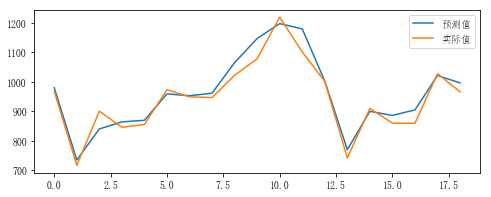

In [13]:

fig, ax = plt.subplots(1, 1, figsize = (8, 3))
ax.plot(testPredict,label='预测值')
ax.plot(testY.T ,label='实际值')
ax.legend()
plt.show()


In [14]:
#预测八月
tmp=np.row_stack((dataset,scaler.transform(999)))
tmp,_=create_dataset(tmp, look_back=12)
print('八月真实值：991.5')
print('八月预测值')
y_gru_8=scaler.inverse_transform(model.predict(tmp[-1].reshape(1,1,12)))[0][0]
print(y_gru_8)
#预测九月
tmp=np.row_stack((dataset,scaler.transform(991.5)))
tmp=np.row_stack((tmp,scaler.transform(99999)))
tmp,_=create_dataset(tmp, look_back=12)
print('九月真实值：1032.1')
print('九月预测值：')
y_gru_9=scaler.inverse_transform(model.predict(tmp[-1].reshape(1,1,12)))[0][0]
print(y_gru_9)

八月真实值：991.5
八月预测值
998.5973
九月真实值：1032.1
九月预测值：
1118.9236


# 时间卷积网络


In [15]:
X_train = np.reshape(x[:train_size], (x[:train_size].shape[0],12,1))
X_test = np.reshape(x[train_size:], (x[train_size:].shape[0],12,1))
y_train=y[:train_size]
y_test=y[train_size:]

from keras.models import load_model

model = load_model('tcn.h5')

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('rmse 训练集' ,trainScore)
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('rmse 测试集' ,testScore)

y_conv1=testPredict


rmse 训练集 26.267723406814056
rmse 测试集 35.932345488100545


In [16]:
#预测八月
tmp=np.row_stack((dataset,scaler.transform(999)))
tmp,_=create_dataset(tmp, look_back=12)
print('八月真实值：991.5')
print('八月预测值')
y_conv1_8=scaler.inverse_transform(model.predict(tmp[-1].reshape(1,12,1)))[0][0]
print(y_conv1_8)
#预测九月
tmp=np.row_stack((dataset,scaler.transform(991.5)))
tmp=np.row_stack((tmp,scaler.transform(99999)))
tmp,_=create_dataset(tmp, look_back=12)
print('九月真实值：1032.1')
print('九月预测值：')
y_conv1_9=scaler.inverse_transform(model.predict(tmp[-1].reshape(1,12,1)))[0][0]
print(y_conv1_9)

八月真实值：991.5
八月预测值
990.3329
九月真实值：1032.1
九月预测值：
1120.074


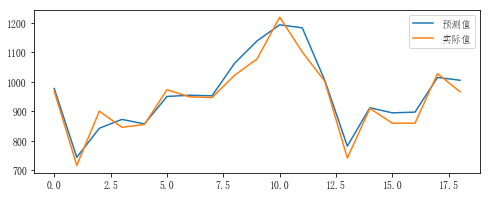

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
ax.plot(testPredict,label='预测值')
ax.plot(testY.T ,label='实际值')
ax.legend()
plt.show()

# 利用分类数据建立环比增长模型
社零额总额分为，吃穿烧用类数据，由于每月结构变化极小，在各分类数据中，利用前12个月的分类数据建立线性回归模型，预测下一个月数据，再根据结构算出的权重汇总

In [28]:
from sklearn.linear_model import LinearRegression
data_all=pd.read_excel('D:\workfile\社零额\额外数据\用途分类数据_环比.xlsx')
index = pd.date_range(start='2010-2', end='2018-9', freq='MS')
data_all.index=index
del data_all['时间']
data_all.columns=['吃类商品','穿类商品','用类商品','烧类商品']
data_all.head()

,吃类商品,穿类商品,用类商品,烧类商品
2010-02-01,0.060714,-0.108429,-0.190800,-0.195322
2010-03-01,-0.202073,-0.138495,0.175565,0.258150
2010-04-01,-0.009078,-0.028475,0.008990,0.155199
2010-05-01,0.051117,0.111570,0.043934,0.017154
2010-06-01,0.031046,-0.073507,0.007467,-0.041433


In [29]:
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
#以吃类商品为例  数据：以2010到2016年数据为训练集，2018年3月到2018年9月为测试集进行尝试性建模
x_eat,y_eat=create_dataset(np.array(data_all['吃类商品']).reshape(104,1), look_back=12)
x_eat_train=x_eat[:-6]
y_eat_train=y_eat[:-6]
x_eat_test=x_eat[-6:]
y_eat_test=y_eat[-6:]

In [31]:
lr=LinearRegression()
lr.fit(x_eat_train,y_eat_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
from sklearn.metrics import mean_squared_error
print('至2018年9月测试集 rmse:')
print(mean_squared_error(lr.predict(x_eat_test),y_eat_test))

至2018年9月测试集 rmse:
0.0015242571131724922


In [27]:
#吃穿用烧 （2018年7月为测试集）
for i in ['吃类商品','穿类商品','用类商品','烧类商品']:
    x_eat,y_eat=create_dataset(np.array(data_all[i]).reshape(104,1), look_back=12)
    x_eat_train=x_eat[:-6]
    y_eat_train=y_eat[:-6]
    x_eat_test=x_eat[-6:-2]
    y_eat_test=y_eat[-6:-2]
    lr=LinearRegression()
    lr.fit(x_eat_train,y_eat_train)
    print(i)
    print(mean_squared_error(lr.predict(x_eat_test),y_eat_test))

吃类商品
0.0016320540656137692
穿类商品
0.0030567540964124796
用类商品
0.0028867316449611704
烧类商品
0.0032530980314681274


In [47]:
#预测八月九月
def lr_predict(data):
    res=[]
    for i in ['吃类商品','穿类商品','用类商品','烧类商品']:       
        x_eat,y_eat=create_dataset(np.array(data[i]).reshape(data.shape[0],1), look_back=12)
        lr=LinearRegression()
        lr.fit(x_eat,y_eat)
        tmp=np.array(data[i]).reshape(data.shape[0],1).copy()
        tmp=np.row_stack((tmp,tmp[-1]))
        tmp,_=create_dataset(tmp,look_back=12)
        res.append(lr.predict(tmp[-1].reshape(1,12)))
    return res
n8_child=lr_predict(data_all[:-2])
n9_child=lr_predict(data_all[:-1])

In [48]:
#八月预测
n7_weight=[0.234255628,0.061317463,0.651243027,0.053183882]
print('八月真实值：991.5')
print('九月预测值')
print((1+np.dot(n7_weight,n8_child))*966.07)
#九月预测
print('九月真实值：1032.1')
n8_weight=[0.230145911,0.059351955,0.65829691,0.052205224]
print((np.dot(n8_weight,n9_child)+1)*991.5)

八月真实值：991.5
九月预测值
[938.07080458]
九月真实值：1032.1
[1068.62243023]


In [101]:
#由于权重变化不大，以7月份权重为依据，给出2017年1月1日到2018年7月1日的估计序列
pred_weight=[]
data_tmp=data.ix['2010-2-1':]
for i in range(83,102):
    tmp=lr_predict(data_all[:i])
    pred_weight.append((np.dot(n7_weight,tmp)+1)*data_tmp.iloc[i,0])
    

In [110]:
testScore = np.sqrt(mean_squared_error(testY[0], np.array(pred_weight)))
print('rmse 测试集' ,testScore)

rmse 测试集 126.34670426538148


In [108]:
pred_weight=np.array(pred_weight)

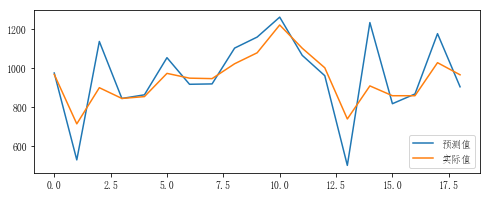

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
ax.plot(pred_weight,label='预测值')
ax.plot(testY.T ,label='实际值')
ax.legend()
plt.show()

# 加权平均组合
神经网络存在过高估计的风险，而SARIMA倾向于较低的预测真实值

In [78]:
#测试集预测结果
y_all=0.3*y_gru7+0.3*y_conv1+0.4*np.array(y_sarima).reshape(19,1)
testScore = np.sqrt(mean_squared_error(y_all, y_truth))
print('rmse 测试集' ,testScore)

rmse 测试集 32.76465749999153


In [80]:
#预测八月
print('八月真实值：991.5')
print('八月预测值')
print(0.3*y_conv1_8+0.3*y_gru_8+0.4*predict_sarima_8)
#预测九月
print('九月真实值：1032.1')
print('九月预测值：')
print(0.3*y_conv1_9+0.3*y_gru_9+0.4*predict_sarima_9)

八月真实值：991.5
八月预测值
987.1975435267041
九月真实值：1032.1
九月预测值：
1094.9791486057534
